In [60]:
cd /home/danish/Documents/research

/home/danish/Documents/research


In [61]:
import subprocess
import pandas as pd
import numpy as np
import random
import os
import time
import progressbar
import matplotlib.pyplot as plt
import math

# Generating Data

In [42]:
#fuction for generating the sythesised MRI signals

def genData(modelsDict, schemeFileLoc, fileName, iterations, groundTruthNames):
    argsList = ["datasynth", "-synthmodel", "compartment"]
    numberOfCompartments = len(modelsDict)
    argsList.append(numberOfCompartments)
    for key in range(numberOfCompartments):
        for value in modelsDict.values()[key]:
            argsList.append(value)
    argsList.extend(("-schemefile", schemeFileLoc, "-voxels", 1, ">", fileName + ".Bfloat", "2>>", fileName + ".log"))
        
    #extra validation
    count = 0
    for value in argsList:
        if type(value) == list:
            count += 1
    if count == 0:
        print "No parameters are being varied"
    if count != len(groundTruthNames):
        print "The number of parameters being varied do not match with the list of columns specifed"
        
    #dataframe used to store the groundtruths in the correct sequence
    groundTruths = pd.DataFrame(np.random.randn(iterations, len(groundTruthNames)), columns = groundTruthNames)
    bar = progressbar.ProgressBar()
    for iteration in bar(range(iterations)):
        args = list(argsList)
        i = 0
        for index, val in enumerate(args):
            if type(val) == list:
                args[index] = random.uniform(val[0], val[1])
                groundTruths.set_value(iteration, groundTruthNames[i], args[index])
                i += 1
            if val == fileName+".Bfloat":
                args[index] = fileName + str(iteration) + ".Bfloat"
            args[index] = str(args[index])
            
        #create a subprocess which calls the command that generates a synthesised MRI signal
        subprocess.call(' '.join(args), shell=True)
        subprocess.call("echo '\n----------\n' >>" + fileName + ".log", shell = True)
    #save groundtruths dataframe as csv file in same loc as .Bfloat files
    groundTruths.to_csv(fileName + "_GroundTruths.csv")
    return groundTruths

In [43]:
#function for converting the .Bfloat files to a 2d numpy-array

def transformData(folderPath):
    
    #create a new datatype that is big-endian and has size of a single-precision float
    dt = np.dtype('>f')
    
    isExec = False
    BFloatFiles = [filename for filename in os.listdir(folderPath) if filename.endswith(".Bfloat")]
    voxelCount = len(BFloatFiles)
    for fileName in BFloatFiles:
        voxArray = np.fromfile(folderPath + "/" + fileName, dtype=dt, sep="")
        if isExec == False:
            finalArray = np.full([voxelCount, len(voxArray)], 0)
            isExec = True
        voxArray = voxArray.reshape((1, voxArray.size))
        
        #get number from fileName
        voxNumber = int(filter(str.isdigit, fileName))
        finalArray[voxNumber] = voxArray
    return finalArray

In [5]:
model1 = { 1: ['Tensor', [0.8E-9, 2.2E-9], 0.0, 0.0, 2.0E-9, 1.4E-9, 0.0]}

#specify the correct location of the scheme file and a generic filename for storing the bfloat files
groundTruths = genData(model1, "PGSE_90.scheme", "./exp1/DT", 1000, ["diffusivity"])

100% |########################################################################|


In [64]:
groundTruths = pd.read_csv("./exp1/DT_GroundTruths.csv", index_col = 0)
data = transformData("./exp1")
y = groundTruths[' '.join(groundTruths.columns.tolist())].values
y_scaled = y * 1E9

# Machine Learning

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

In [66]:
#we first randomly split the data into a training and testing set of ratio 7:3
np.random.seed(0)
indices = np.random.permutation(len(data))
num = int(len(data)*0.7)
X_train = data[indices[:num]]
y_train = y_scaled[indices[:num]]
X_test  = data[indices[num:]]
y_true  = y_scaled[indices[num:]]

Feature Visualisation

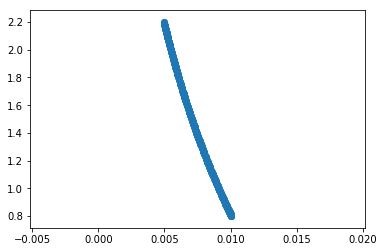

In [9]:
%matplotlib inline
plt.scatter (X_train[:,0], y_train)
#plt.scatter (X_train[:,1], y_train)
#plt.scatter (X_train[:,2], y_train)

Experiment 1

Model Used = Diffusion Tensor

Parameters being predicted: Diffusivity in a single direction

Ridge Regression

In [67]:
reg = linear_model.RidgeCV()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [11]:
print "explained varience score: ", metrics.explained_variance_score(y_true, y_pred)
print "mean absolute error: ", metrics.mean_absolute_error(y_true, y_pred)
print "mean squared error: ", metrics.mean_squared_error(y_true, y_pred)
print "r2_score: ", metrics.r2_score(y_true, y_pred)

explained varience score:  0.9997111875
mean absolute error:  0.00589938498875
mean squared error:  4.83665628086e-05
r2_score:  0.999710463001


Random Forest Regressor

In [68]:
rfReg = RandomForestRegressor(n_estimators = 1)
rfReg.fit(X_train, y_train)
rfy_pred = rfReg.predict(X_test)

In [13]:
print "explained varience score: ", metrics.explained_variance_score(y_true, rfy_pred)
print "mean absolute error: ", metrics.mean_absolute_error(y_true, rfy_pred)
print "mean squared error: ", metrics.mean_squared_error(y_true, rfy_pred)
print "r2_score: ", metrics.r2_score(y_true, rfy_pred)

explained varience score:  0.999973998234
mean absolute error:  0.0015177084665
mean squared error:  4.3440380656e-06
r2_score:  0.999973995263


In [90]:
def bland_altman_plot(y_true, rfy_pred, *args, **kwargs):
    data1     = np.asarray(y_true)
    data2     = np.asarray(rfy_pred)
    mean      = np.mean([y_true, rfy_pred], axis=0)
    diff      = y_true - rfy_pred                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    
   
  

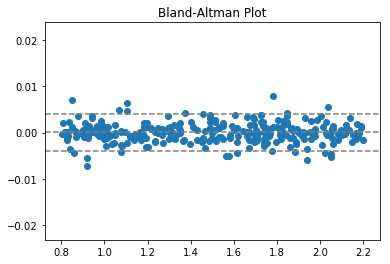

In [91]:
from numpy.random import random

bland_altman_plot(y_true, rfy_pred)
plt.title('Bland-Altman Plot')
plt.show()

In [78]:
y_true

array([ 1.23619263,  1.49063219,  1.34503445,  2.05652219,  1.51623706,
        1.69612949,  1.32705276,  1.49273619,  1.70321306,  0.98602031,
        1.24979224,  0.82410872,  1.67093644,  1.04673863,  0.99230057,
        1.05078121,  1.92904822,  1.10804757,  1.04873514,  1.49198367,
        1.93868248,  1.82556985,  1.51653531,  2.0106038 ,  1.72731567,
        1.55330134,  0.91109767,  1.97584359,  2.05885839,  2.1000698 ,
        1.02365816,  1.71064987,  1.96202362,  1.30325242,  1.53231044,
        1.93217243,  1.01458809,  1.75537243,  1.23409967,  0.99937025,
        1.74085136,  1.90129737,  1.24641265,  1.32489878,  1.58308867,
        1.45468392,  1.69476957,  1.14262724,  2.10480626,  0.86174859,
        1.49043652,  1.49936562,  2.1214858 ,  1.46269986,  2.0048089 ,
        1.33326424,  1.19632101,  2.05335572,  1.88891279,  1.01626642,
        0.94476146,  2.01563468,  0.87201344,  1.75692792,  0.92441392,
        1.31274784,  1.70469374,  1.69302249,  1.04672388,  1.73

In [79]:
rfy_pred

array([ 1.23615054,  1.48968325,  1.34414572,  2.05581758,  1.51382676,
        1.69324406,  1.32847338,  1.48968325,  1.70493387,  0.98620084,
        1.24994619,  0.82565608,  1.67245905,  1.04714954,  0.99092717,
        1.05094367,  1.92909366,  1.10331591,  1.04714954,  1.48968325,
        1.94226723,  1.82545365,  1.51382676,  2.01325169,  1.72346833,
        1.55130271,  0.90892912,  1.97653944,  2.05809661,  2.09983764,
        1.02439721,  1.71064983,  1.95957272,  1.30341099,  1.53124807,
        1.92909366,  1.01511096,  1.75766772,  1.23615054,  0.99963305,
        1.74082652,  1.90142881,  1.24590185,  1.32323313,  1.58422318,
        1.45586814,  1.69324406,  1.14300821,  2.10501462,  0.8613674 ,
        1.48968325,  1.49954352,  2.11975593,  1.46613744,  2.00122738,
        1.33371891,  1.19506338,  2.05321195,  1.89097864,  1.01511096,
        0.94116468,  2.01445029,  0.87258261,  1.75766772,  0.92505173,
        1.31271416,  1.70493387,  1.69324406,  1.04714954,  1.74

SVM Regression

In [14]:
from sklearn import svm
clf = svm.SVR(kernel='linear')
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

In [15]:
print "explained varience score: ", metrics.explained_variance_score(y_true, clf_pred)
print "mean absolute error: ", metrics.mean_absolute_error(y_true, clf_pred)
print "mean squared error: ", metrics.mean_squared_error(y_true, clf_pred)
print "r2_score: ", metrics.r2_score(y_true, clf_pred)

explained varience score:  0.98262403216
mean absolute error:  0.0642864386265
mean squared error:  0.00499662747771
r2_score:  0.970088663714


K-Nearest Neighbour

In [16]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors = 2, weights = "distance")
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [17]:
print "explained varience score: ", metrics.explained_variance_score(y_true, knn_pred)
print "mean absolute error: ", metrics.mean_absolute_error(y_true, knn_pred)
print "mean squared error: ", metrics.mean_squared_error(y_true, knn_pred)
print "r2_score: ", metrics.r2_score(y_true, knn_pred)

explained varience score:  0.999992076815
mean absolute error:  0.000686893217966
mean squared error:  1.32756912614e-06
r2_score:  0.999992052766


In [18]:
y_true

array([ 1.23619263,  1.49063219,  1.34503445,  2.05652219,  1.51623706,
        1.69612949,  1.32705276,  1.49273619,  1.70321306,  0.98602031,
        1.24979224,  0.82410872,  1.67093644,  1.04673863,  0.99230057,
        1.05078121,  1.92904822,  1.10804757,  1.04873514,  1.49198367,
        1.93868248,  1.82556985,  1.51653531,  2.0106038 ,  1.72731567,
        1.55330134,  0.91109767,  1.97584359,  2.05885839,  2.1000698 ,
        1.02365816,  1.71064987,  1.96202362,  1.30325242,  1.53231044,
        1.93217243,  1.01458809,  1.75537243,  1.23409967,  0.99937025,
        1.74085136,  1.90129737,  1.24641265,  1.32489878,  1.58308867,
        1.45468392,  1.69476957,  1.14262724,  2.10480626,  0.86174859,
        1.49043652,  1.49936562,  2.1214858 ,  1.46269986,  2.0048089 ,
        1.33326424,  1.19632101,  2.05335572,  1.88891279,  1.01626642,
        0.94476146,  2.01563468,  0.87201344,  1.75692792,  0.92441392,
        1.31274784,  1.70469374,  1.69302249,  1.04672388,  1.73

In [19]:
knn_pred

array([ 1.23619264,  1.48909226,  1.3450348 ,  2.05652242,  1.51402961,
        1.69494522,  1.32669462,  1.49274037,  1.70486344,  0.9863552 ,
        1.24979235,  0.82411007,  1.67286392,  1.04746506,  0.99043388,
        1.05078125,  1.92904824,  1.10805028,  1.04873576,  1.48875082,
        1.94079823,  1.82556988,  1.51653684,  2.01343184,  1.72381556,
        1.5534722 ,  0.91048711,  1.9758436 ,  2.05805681,  2.10006993,
        1.02389782,  1.71064993,  1.95951821,  1.30325246,  1.53231077,
        1.92839418,  1.0150804 ,  1.7553732 ,  1.23605117,  0.99984241,
        1.74080866,  1.90152741,  1.24641277,  1.32590657,  1.58308906,
        1.45586786,  1.69476977,  1.14262751,  2.10482462,  0.86174882,
        1.48917461,  1.49936565,  2.12148597,  1.46270139,  2.00480901,
        1.33326429,  1.1951054 ,  2.05335579,  1.89048928,  1.01626681,
        0.94239456,  2.01563481,  0.87201362,  1.75692843,  0.92441414,
        1.3126822 ,  1.70483967,  1.69318805,  1.04747367,  1.74

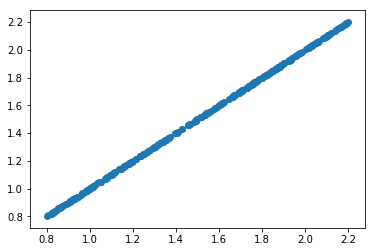

In [20]:
%matplotlib inline
plt.scatter(y_true, knn_pred)

# BallCylinder 

Predicts Paramaeters:

Intra axonal diffusivity (Cylinder)
Intra axonal axon radius (single) (Cylinder)
Extra axonal diffusivity (Ball)

In [17]:
model3 = { 1: ['CylinderGPD', [0.0, 1.0], [0.8E-9, 2.2E-9], [0.0, 0.0], 1.5E-9, 2.5E-9], 2: ['Ball', [0.8E-9, 2.2E-9]]}

groundTruths3 = genData(model3, "PGSE_90.scheme", "./exp3/BallCylinder", 1000, ["BallCylinderVolumeFraction", "intraD", "extraD", "axonr"])

100% |########################################################################|


In [18]:
groundTruths3 = pd.read_csv("./exp3/BallCylinder_GroundTruths.csv", index_col = 0)
data3 = transformData("./exp3")
y3 = groundTruths3.values

/home/danish/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full([1000, 360], 0) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [19]:
#we can use the standard scaler implementation in sklearn to scale the ground-truth valuse before training
y3 = preprocessing.scale(y3)

In [20]:
np.random.seed(0)
indices = np.random.permutation(len(data3))
num = int(len(data3)*0.7)
X_train3 = data3[indices[:num]]
y_train3 = y3[indices[:num]]
X_test3  = data3[indices[num:]]
y_true3  = y3[indices[num:]]

Ridge Regression

In [21]:
reg3 = linear_model.RidgeCV()
reg3.fit(X_train3, y_train3)
y_pred3 = reg3.predict(X_test3)

In [22]:
print "explained varience score: ", metrics.explained_variance_score(y_true3, y_pred3, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true3, y_pred3, multioutput='variance_weighted')

explained varience score:  0.836261713005
r2_score:  0.835884444012


K-Nearest Neighbours

In [23]:
from sklearn import neighbors
knn3 = neighbors.KNeighborsRegressor(n_neighbors = 2, weights = "distance")
knn3.fit(X_train3, y_train3)
knn_pred3 = knn3.predict(X_test3)

In [24]:
print "explained varience score: ", metrics.explained_variance_score(y_true3, knn_pred3, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true3, knn_pred3, multioutput='variance_weighted')

explained varience score:  0.863667009051
r2_score:  0.863123115207


Below we use a grid search with three fold cross validation to find optimal parameters for the learning algorithm.
The parameters selected are those that maximise the r2 score.

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
grid_parameters = {'n_neighbors':[2,3,4,5,10], 'weights':("uniform", "distance")}
scorer = make_scorer(metrics.r2_score, multioutput="variance_weighted")
knn3_grid = GridSearchCV(neighbors.KNeighborsRegressor(), grid_parameters, scoring=scorer, verbose=1)
knn3_grid.fit(X_train3, y_train3)
print "\nBest Params: ", knn3_grid.best_params_ 
knn3_grid_pred = knn3_grid.predict(X_test3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Params:  {'n_neighbors': 4, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Params:  {'n_neighbors': 5, 'weights': 'distance'}

In [34]:
print "explained varience score: ", metrics.explained_variance_score(y_true3, knn3_grid_pred, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true3, knn3_grid_pred, multioutput='variance_weighted')

explained varience score:  0.882791098559
r2_score:  0.882749133671


Random Forest

With grid search and 3-fold cross validation

In [35]:
grid_parameters = {'n_estimators':[5,10,25,50,100], 'max_depth':[20,50,100]}
rfReg = RandomForestRegressor()
rfReg3_grid = GridSearchCV(rfReg, grid_parameters, scoring=scorer, verbose=1)
rfReg3_grid.fit(X_train3, y_train3)
rfReg3_grid_pred = rfReg3_grid.predict(X_test3)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.6min finished


Fitting 3 folds for each of 15 candidates, totalling 45 fits

In [36]:
print "\nBest Params: ", knn3_grid.best_params_ 
print "explained varience score: ", metrics.explained_variance_score(y_true3, rfReg3_grid_pred, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true3, rfReg3_grid_pred, multioutput='variance_weighted') 
print "r2_score: ", metrics.r2_score(y_true3, rfReg3_grid_pred, multioutput='uniform_average')


Best Params:  {'n_neighbors': 4, 'weights': 'distance'}
explained varience score:  0.900839228558
r2_score:  0.900786900273
r2_score:  0.924527876255


In [38]:
rfReg3_grid_pred

array([[ 0.14665384, -1.31137782,  0.        , -1.14510419],
       [-1.22869911,  0.6469339 ,  0.        , -0.75017116],
       [-1.32332695,  0.0081436 ,  0.        ,  0.12878993],
       ..., 
       [-1.38858794,  1.08065958,  0.        ,  1.49349335],
       [ 1.10579524, -1.38359501,  0.        , -0.11703233],
       [ 1.58965966, -1.41449933,  0.        ,  0.65970841]])

In [32]:
y_true3

array([[-0.05272795, -1.25593164,  0.        , -1.44626689],
       [-1.21088328,  1.11168023,  0.        , -0.8397196 ],
       [-1.38376292, -0.11601903,  0.        ,  0.03084655],
       ..., 
       [-1.38067812,  1.45657334,  0.        ,  1.34367759],
       [ 0.95082855, -1.41154162,  0.        , -1.1709922 ],
       [ 1.57336801, -1.38778363,  0.        , -1.46883892]])

# TensorCylinder

Intra-axonal diffusivity (Cylinder)
Intra-axonal radius (Cylinder)
Extra-axonal diffusivity in 3 directions (Full Tensor)

In [45]:
model4 = { 1: ['CylinderGPD', [0.0, 1.0], [0.8E-9, 2.2E-9], [0.0, 0.0], 1.5E-9, 2.5E-9], 2: ['Tensor', [0.8E-9, 2.2E-9], 0.0, 0.0, [0.8E-9, 2.2E-9], [0.8E-9, 2.2E-9], 0.0]}

groundTruths4 = genData(model4, "PGSE_90.scheme", "./exp4/TensorCylinder", 1000, ["TensorCylinder", "intraD", "intraR", "extraD1", "extraD2", "extraD3"])

100% |########################################################################|


In [47]:
groundTruths4 = pd.read_csv("./exp4/TensorCylinder_GroundTruths.csv", index_col = 0)
data4 = transformData("./exp4")
y4 = groundTruths4.values * 1E9

In [48]:
#we can use the standard scaler implementation in sklearn to scale the ground-truth valuse before training
y4 = preprocessing.scale(y4)

In [49]:
np.random.seed(0)
indices = np.random.permutation(len(data4))
num = int(len(data4)*0.7)
X_train4 = data4[indices[:num]]
y_train4 = y4[indices[:num]]
X_test4  = data4[indices[num:]]
y_true4  = y4[indices[num:]]

Ridge Regression

In [50]:
reg4 = linear_model.RidgeCV()
reg4.fit(X_train4, y_train4)
y_pred4 = reg4.predict(X_test4)

In [51]:
print "explained varience score: ", metrics.explained_variance_score(y_true4, y_pred4, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true4, y_pred4, multioutput='variance_weighted')

explained varience score:  0.796607081024
r2_score:  0.795123781296


K-Nearest Neighbours

In [52]:
from sklearn import neighbors
knn4 = neighbors.KNeighborsRegressor(n_neighbors = 2, weights = "distance")
knn4.fit(X_train4, y_train4)
knn_pred4 = knn4.predict(X_test4)

In [53]:
print "explained varience score: ", metrics.explained_variance_score(y_true4, knn_pred4, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true4, knn_pred4, multioutput='variance_weighted')

explained varience score:  0.667230724627
r2_score:  0.662742213965


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
grid_parameters = {'n_neighbors':[2,3,4,5,10], 'weights':("uniform", "distance")}
scorer = make_scorer(metrics.r2_score, multioutput="variance_weighted")
knn4_grid = GridSearchCV(neighbors.KNeighborsRegressor(), grid_parameters, scoring=scorer, verbose=1)
knn4_grid.fit(X_train4, y_train4)
print "\nBest Params: ", knn4_grid.best_params_ 
knn4_grid_pred = knn4_grid.predict(X_test4)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Params:  {'n_neighbors': 5, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    7.3s finished


In [55]:
print "explained varience score: ", metrics.explained_variance_score(y_true4, knn4_grid_pred, multioutput='variance_weighted')
print "r2_score: ", metrics.r2_score(y_true4, knn4_grid_pred, multioutput='variance_weighted')

explained varience score:  0.684636881739
r2_score:  0.680396830446


Random Forest


In [56]:
grid_parameters = {'n_estimators':[5,10,25,50,100], 'max_depth':[20,50,100]}
rfReg = RandomForestRegressor()
rfReg4_grid = GridSearchCV(rfReg, grid_parameters, scoring=scorer, verbose=1)
rfReg4_grid.fit(X_train4, y_train4)
rfReg4_grid_pred = rfReg4_grid.predict(X_test4)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  5.8min finished


In [57]:
print "\nBest Params: ", knn4_grid.best_params_ 
print "explained varience score: ", metrics.explained_variance_score(y_true4, rfReg4_grid_pred, multioutput='variance_weighted')
print "mean absolute error: ", metrics.mean_absolute_error(y_true4, rfReg4_grid_pred)
print "mean squared error: ", metrics.mean_squared_error(y_true4, rfReg4_grid_pred)
print "r2_score: ", metrics.r2_score(y_true4, rfReg4_grid_pred, multioutput='variance_weighted') 
print "r2_score: ", metrics.r2_score(y_true4, rfReg4_grid_pred, multioutput='uniform_average')


Best Params:  {'n_neighbors': 5, 'weights': 'distance'}
explained varience score:  0.687382567317
mean absolute error:  0.328299681807
mean squared error:  0.26164370431
r2_score:  0.685805352585
r2_score:  0.741913363248


In [58]:
rfReg4_grid_pred

array([[ 0.59880968,  0.69819723,  0.        , -0.855152  ,  0.0476268 ,
         0.01668798],
       [-1.36365085,  0.08459499,  0.        , -1.11796349,  0.16357701,
         0.89289636],
       [-1.61725225, -0.05420225,  0.        ,  1.18929362,  1.03548479,
         0.6849477 ],
       ..., 
       [-0.64928888, -1.03014104,  0.        , -0.3912834 ,  0.50574134,
         0.02618089],
       [ 0.33860946, -1.39749214,  0.        , -0.83983608, -0.26815141,
        -0.93737799],
       [-0.99821259,  0.73537668,  0.        , -1.04837886,  0.33636362,
         0.51944919]])

In [59]:
y_true4

array([[ 0.66165492,  0.66574406,  0.        , -1.08779489,  0.240039  ,
        -0.02977212],
       [-1.39725667,  0.96944522,  0.        , -1.15691211, -0.23490031,
         0.84838809],
       [-1.66680864,  1.23970756,  0.        ,  1.05093886,  1.31837019,
         0.34272308],
       ..., 
       [-0.82807634, -1.65955969,  0.        , -0.18144525, -0.05182882,
         0.06268255],
       [-0.0954852 , -1.60073986,  0.        , -0.95082688, -1.53992855,
        -1.70725513],
       [-0.93662496,  1.09466018,  0.        , -1.08400271,  0.27665271,
         0.58316485]])